#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [ ]:
hdr = db[{{ uid }}]

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [3]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [ ]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

In [4]:
%run develop.py
%run two_time.py

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [6]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [7]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid='ec41569e'  #a gisaxs example, 
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
 
    
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [11]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


### Get data path

In [12]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/8/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [13]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask
#### load the mask saved in the mask_pipeline

In [15]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [16]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


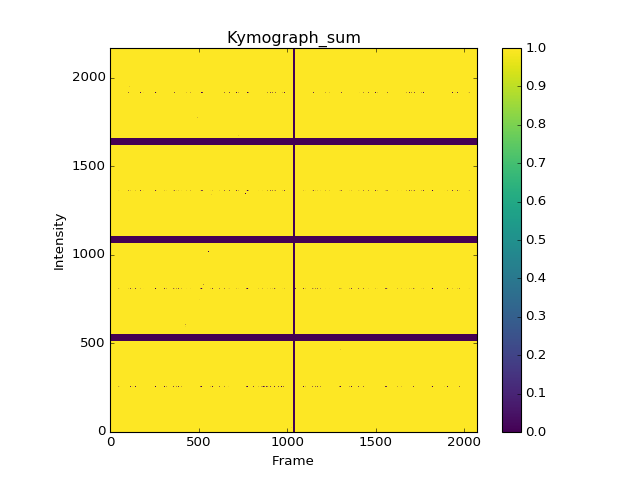

In [17]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [18]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [19]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [20]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [21]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [47]:
bad_frames = np.where( kymo_sum > 1e10)[0]
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

<IPython.core.display.Javascript object>


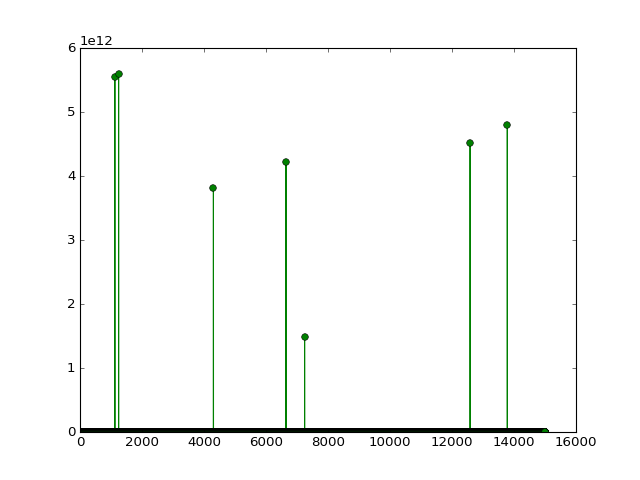

In [22]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [23]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [24]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

# NOTE:


* mask:   the mask file in the python conventional coordination
* maskr:  the mask file in the eiger coordination (maksr = mask[::-1,:])
* avg_img: the average intensity frames in the python conventional coordination
* avg_imgm: the maksed average intensity frames in the python conventional coordination (avg_imgm =  avg_img * mask)   
* avg_imgr: the average intensity frames in the eiger coordination (avg_imgr  = avg_img[::-1,:] )
* avg_imgmr: the maksed average intensity frames in the eiger coordination (avg_imgmr  = avg_imgm[::-1,:] )

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


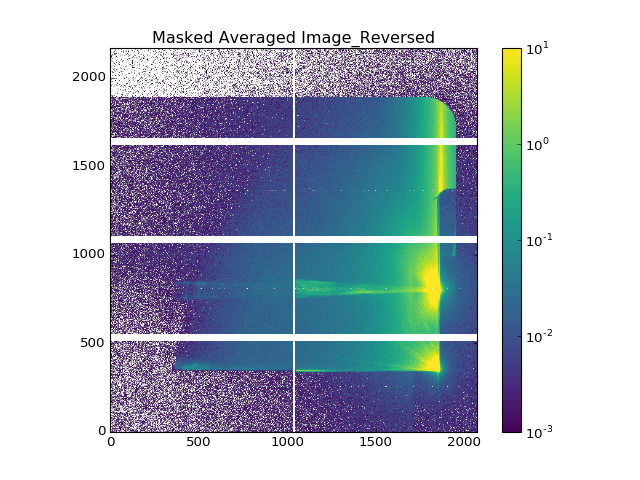

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)


In [26]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## GiSAXS get q-map (qz and qr)

### Users put incident-Beam and Reflection_Beam Centers here!!!

In [27]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [28]:
lamda

1.3776

In [29]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [30]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


<IPython.core.display.Javascript object>


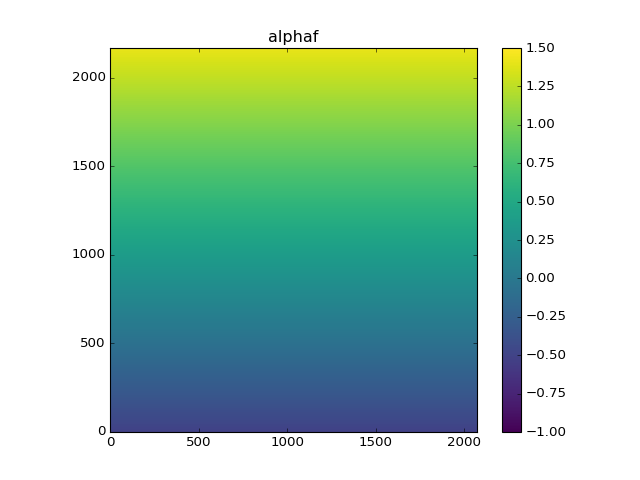

In [31]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(alphaf*180/np.pi, origin='lower' ,cmap='viridis',vmin=-1,vmax= 1.5 )
fig.colorbar(im)
ax.set_title( 'alphaf')
plt.show()

<IPython.core.display.Javascript object>


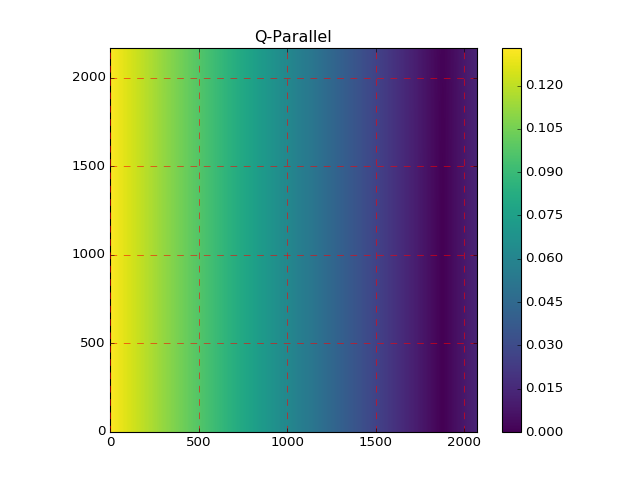

In [56]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.grid(True, which='both', color='r', linestyle='--')
ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

<IPython.core.display.Javascript object>


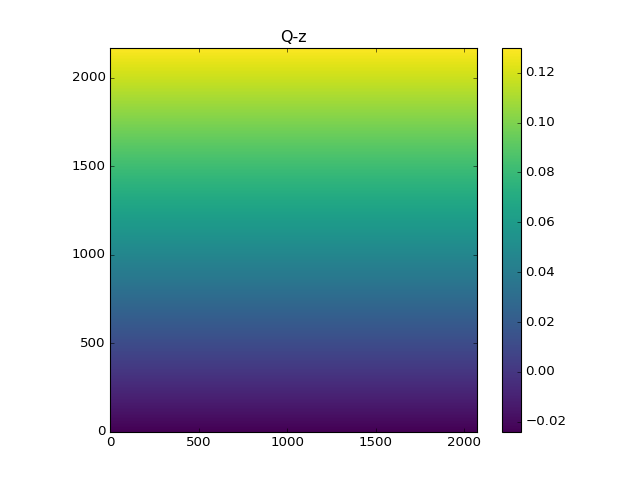

In [39]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max() )
fig.colorbar(im)
ax.set_title( 'Q-z')
plt.show()

# Get q||-intensity

## Users put cuts here!!!

<IPython.core.display.Javascript object>


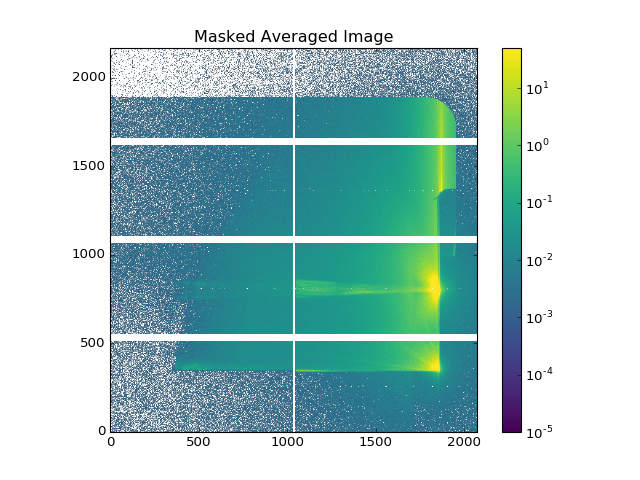

In [57]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e2 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

In [58]:
vert_rect = ( ( 850, 0, 980- 850, 1600-0) , ( 570, 0, 700- 570, 1600-0) )    #(y,x, hight, wdith)

In [59]:
new_mask = np.ones_like( avg_imgr)
new_mask[ :, 1020:1045] =0

<IPython.core.display.Javascript object>


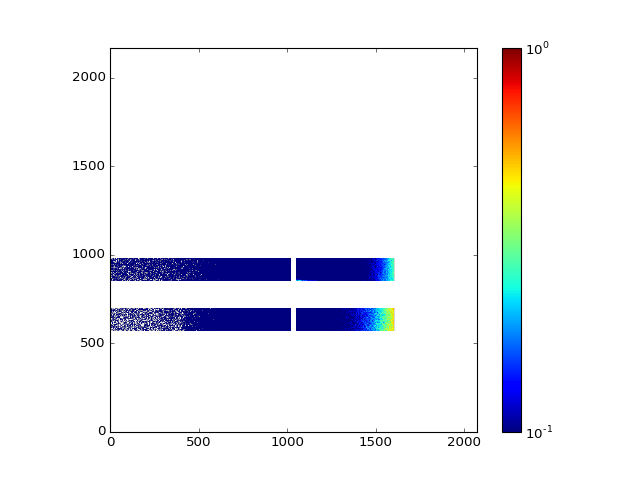

<IPython.core.display.Javascript object>


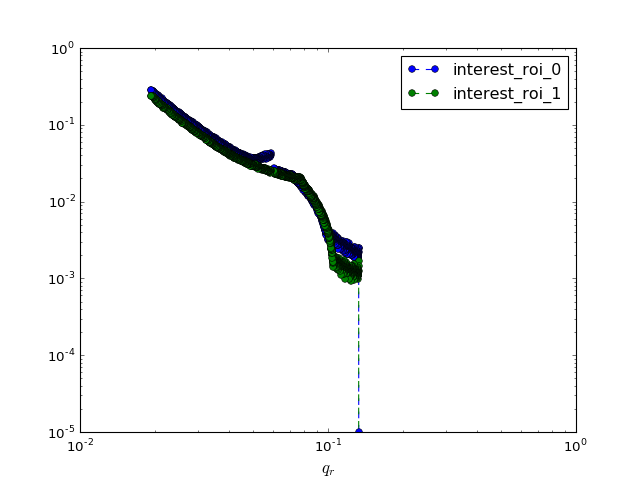

0 (850, 0, 130, 1600)
1 (570, 0, 130, 1600)


In [43]:
get_qr_intensity( qr, avg_imgr, vert_rect, mask=new_mask, show_roi=True)

## User gives the interested Qz,Qr here!!! 

In [60]:
qz_start = qz[670,0]
qz_end = qz[950,0]
qz_num= 2


qr_start =  qr[600,1700]
qr_end = qr[600,0]
qr_num = 15

## Create label array (Qz, Qr, Qzr boxes)

In [61]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/qr_num, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num -0) , qz_num )

label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))


In [62]:
num_qz,num_qr,num_qzr

(2, 15, 30)

<IPython.core.display.Javascript object>


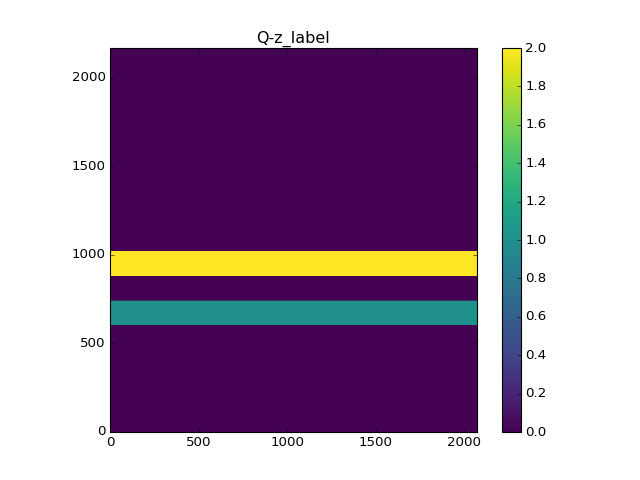

In [63]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-z_label')
plt.show()

<IPython.core.display.Javascript object>


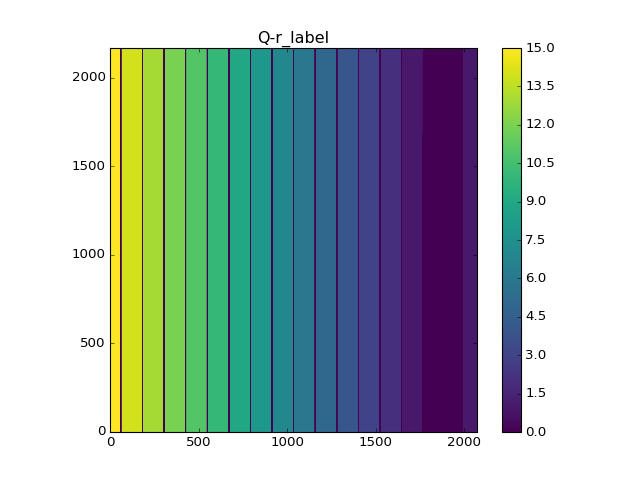

In [64]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

## Extract the labeled array

In [67]:
boxes = label_array_qzr 
box_maskr = boxes*maskr


In [68]:
qind, pixelist = roi.extract_label_indices(   box_maskr  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:] 

## Number of pixels in each q ring

In [69]:
nopr

array([27383, 15846, 15707, 15707, 15846, 15290, 15845, 15697, 15706,
       15846, 15703, 15843, 15707, 15846,  7922, 27776, 16074, 15933,
       15933, 16074, 15508, 16074, 15933, 15933, 16039, 15933, 16074,
       15933, 16074,  8037])


## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


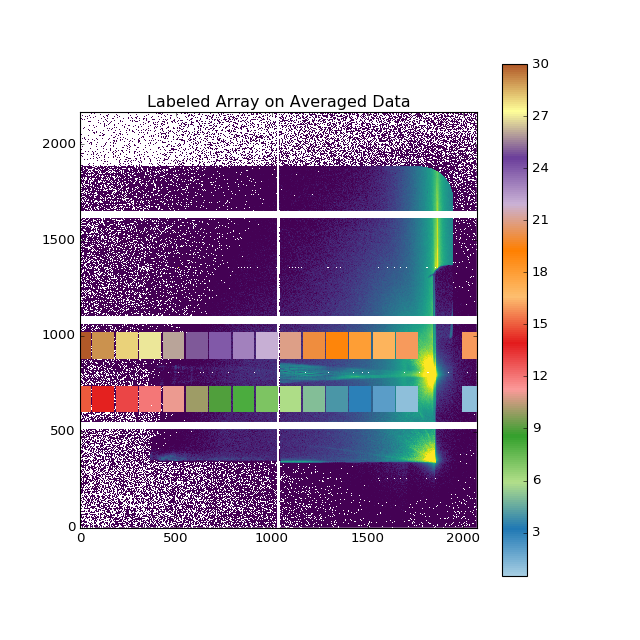

In [144]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im,im_label = show_label_array_on_image(axes, avg_imgr, box_maskr, imshow_cmap='viridis',
                        cmap='Paired',
                         vmin=0.01, vmax=30. ,  origin="lower")
#rwidth = 200 
#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

#fig.colorbar(im)
fig.colorbar(im_label)
plt.show()

##  Kymograph(waterfall plot) of the max-intensity ring

In [72]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, maskr)    

In [73]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
run_time(t0)

Total time: 7.11 min


### users put the number of ring with max intensity here

In [74]:
max_inten_ring =2

In [75]:
#kymo = roi.kymograph(imgsr, ring_mask, num = max_inten_ring)

In [76]:
pixelist_qi =  np.where( qind == max_inten_ring )[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

In [77]:
data_pixel_qi.shape

(15000, 15846)

<IPython.core.display.Javascript object>


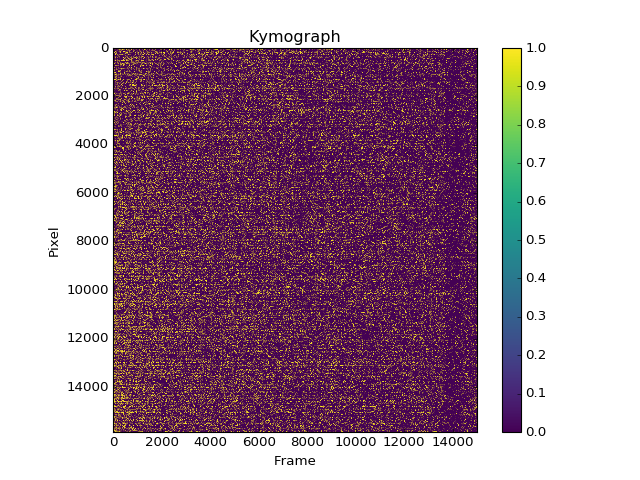

In [78]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(1.)
plt.show()

<IPython.core.display.Javascript object>


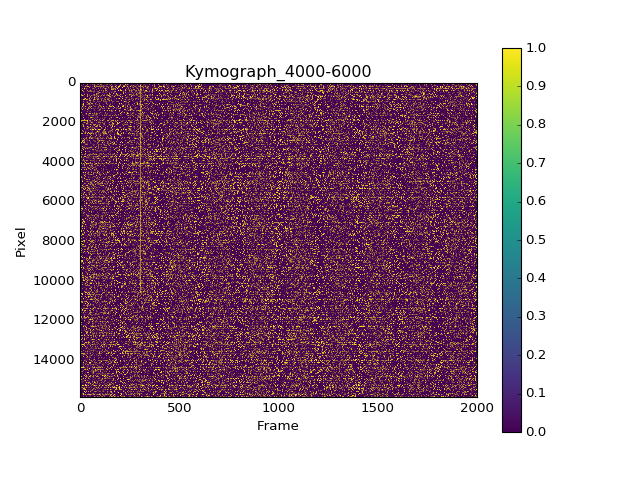

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_4000-6000')

im = ax.imshow(data_pixel_qi[4000:6000,:].T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.1)
plt.show()

##  Mean intensities for each ring

In [80]:
mean_inten = get_mean_intensity( data_pixel, qind)

<IPython.core.display.Javascript object>


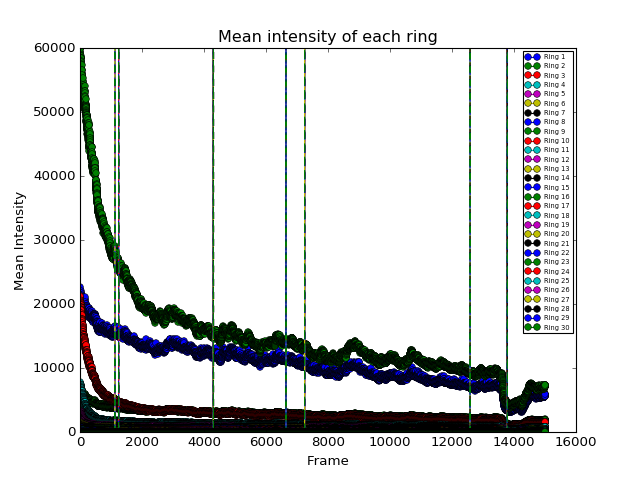

In [248]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each ring")
for i in range(  num_qzr  ):
    ax.plot(times, mean_inten[i+1], '--o', label="Ring "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 6e4)
    
ax.legend( fontsize = 6) 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [82]:
nopr

array([27383, 15846, 15707, 15707, 15846, 15290, 15845, 15697, 15706,
       15846, 15703, 15843, 15707, 15846,  7922, 27776, 16074, 15933,
       15933, 16074, 15508, 16074, 15933, 15933, 16039, 15933, 16074,
       15933, 16074,  8037])

In [83]:
good_start =4000
good_end = 12001

imgs_ =imgs[good_start: good_end-1]
imgsr = Reverse_Coordinate(imgs_, mask) 

num_buf = 8


In [84]:
g2_tx1, lag_steps_tx1 = autocor_one_time( num_buf,  box_maskr, imgsr, num_lev=None,
                                bad_images=None, threshold= 5000 )

 
                                       

The lev number is 12
Doing g2 caculation of 8000 frames---
#bad image: 304 here!
###bad image: 2645 here!
#bad image: 3245 here!
#####Total time: 19.53 min


In [85]:
g2, lag_steps = g2_tx1, lag_steps_tx1
lags = lag_steps*timeperframe

In [86]:
qz_center,qr_center

(array([ 0.02353945,  0.04345093]),
 array([ 0.01216096,  0.02079352,  0.02942609,  0.03805865,  0.04669122,
         0.05532378,  0.06395634,  0.07258891,  0.08122147,  0.08985404,
         0.0984866 ,  0.10711917,  0.11575173,  0.1243843 ,  0.13301686]))

In [99]:
#plt.close('all')

In [88]:
tg2 = np.hstack( [ lags.reshape( len(lags),1), g2] )
#np.save( path + 'g2_%s-%s--%s'%(uid,good_start, good_end), tg2)
np.savetxt( path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end), tg2)

### Plot the one time correlation functions

<IPython.core.display.Javascript object>


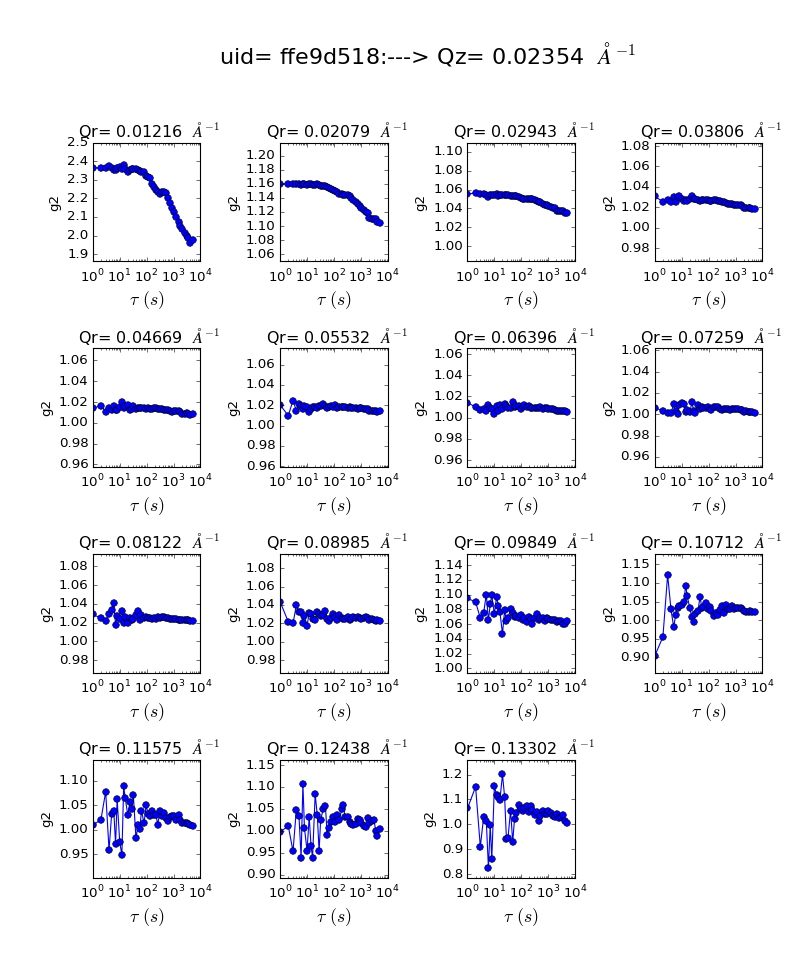

<IPython.core.display.Javascript object>


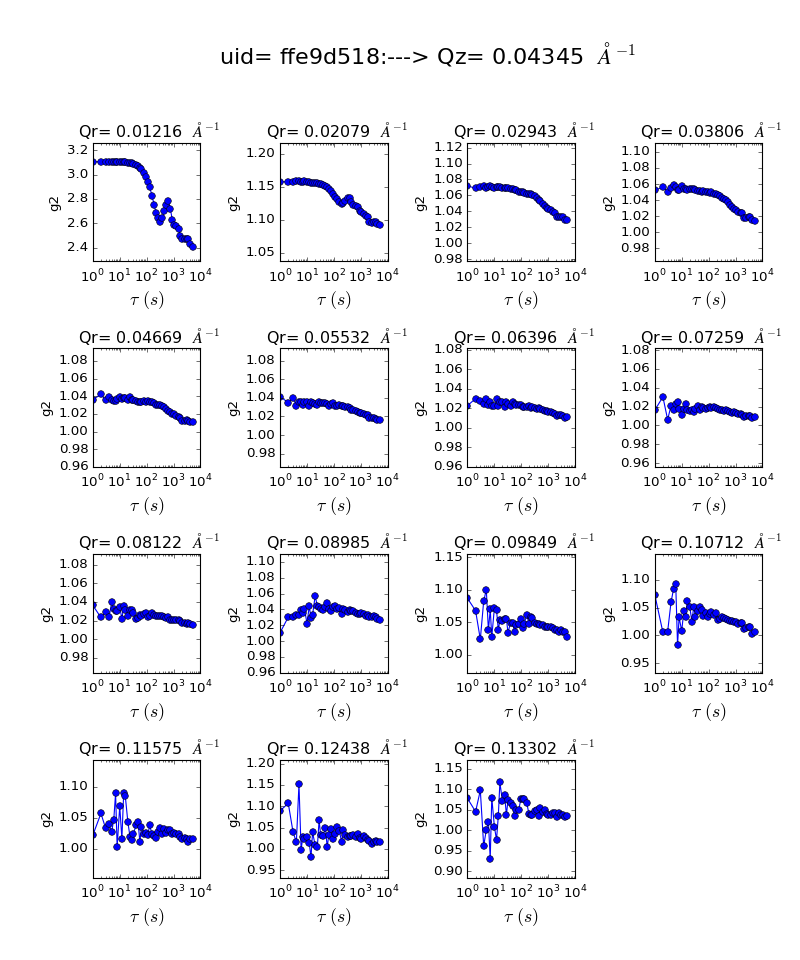

In [100]:
vmin = 1.1
vmax=  1.15

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
            
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-o', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  


#np.save( path + 'g2_%s--%s'%(good_start, good_end), [lags,g2])
#lags,g2 = np.load( path + 'g2_%s--%s.npy'%(good_start, good_end) )

# Fit g2

In [90]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


<IPython.core.display.Javascript object>


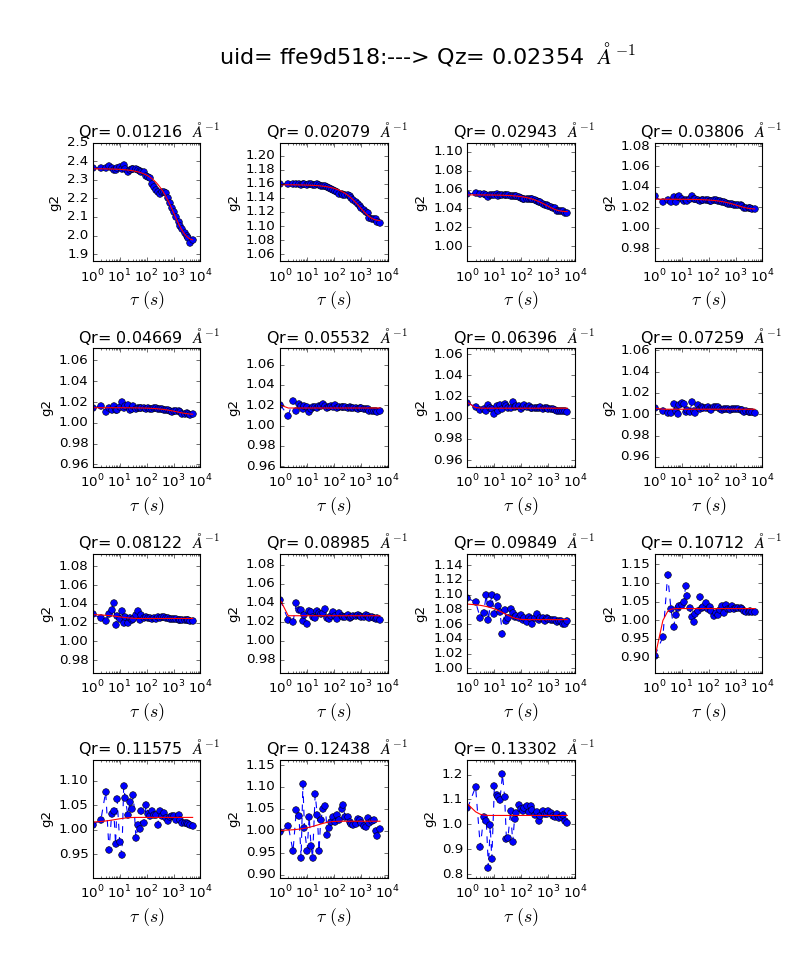

<IPython.core.display.Javascript object>


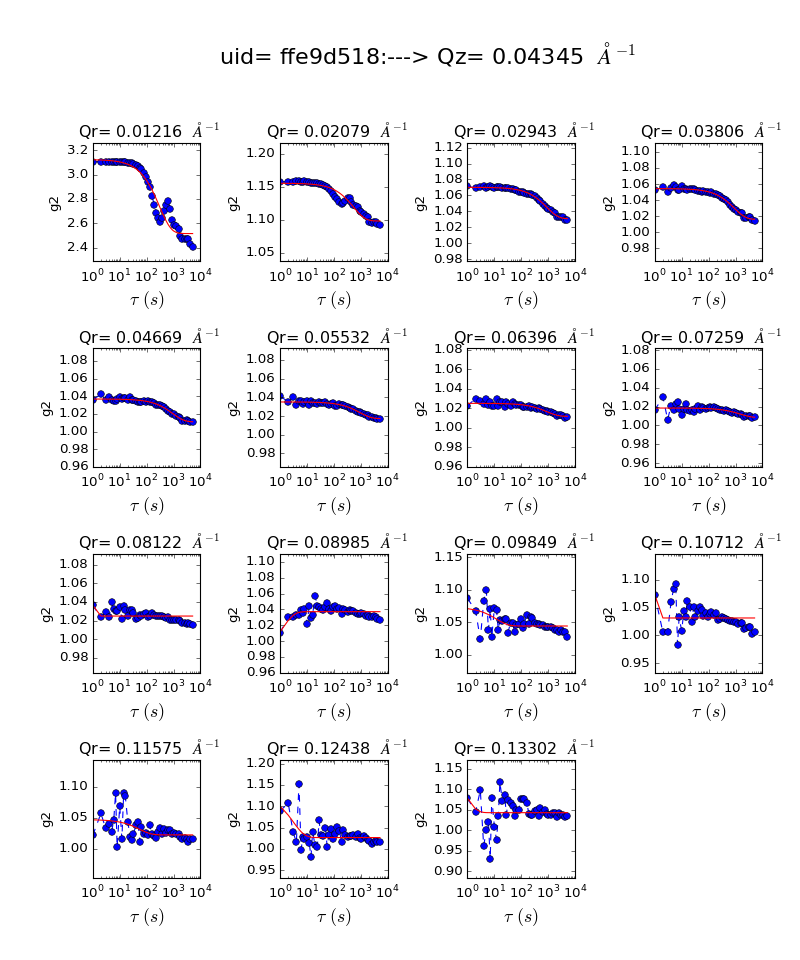

In [101]:
vmin = 1.1
vmax=  1.15

rate = {}

for qz_ind in range(num_qz):
    rate[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
            
        y=g2[1:, sn + qz_ind * num_qr]
        result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
        rate[qz_ind].append(result1.best_values['relaxation_rate'])
    
        ax.semilogx(lags[1:], y, '--o', markersize=6) 
        ax.semilogx(lags[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  



## Plot the relaxation rates vs (q_ring_center)**2

<IPython.core.display.Javascript object>


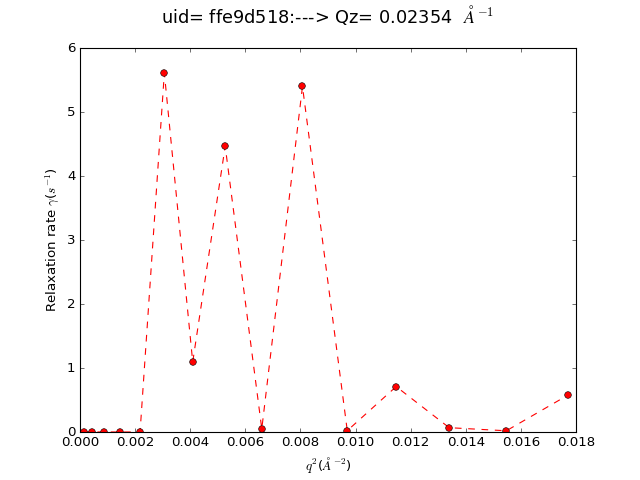

<IPython.core.display.Javascript object>


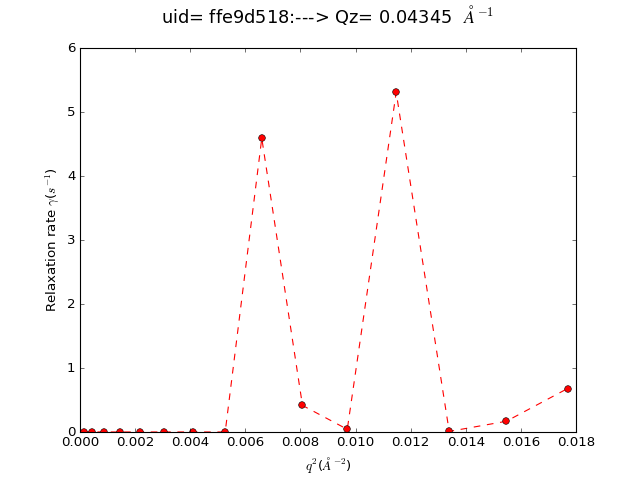

In [102]:
for qz_ind in range(num_qz):     
    #fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    fig, ax=plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    #if num_qz!=1:plt.axis('off')
        
    ax.plot(qr_center**2, rate[qz_ind], 'ro', ls='--')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
    
    plt.show()
 

# Fitted the Diffusion Coefficinet D0

In [93]:
if True:
    D0={}
    gmfit={}
    for qz_ind in range(num_qz): 
        D0[qz_ind] = np.polyfit(qr_center**2, rate[qz_ind], 1)
        gmfit[qz_ind] = np.poly1d( D0[qz_ind] )
        print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[qz_ind][0])

The fitted diffusion coefficient D0 is:  -2.41E+01   A^2S-1
The fitted diffusion coefficient D0 is:  7.56E+01   A^2S-1


<IPython.core.display.Javascript object>


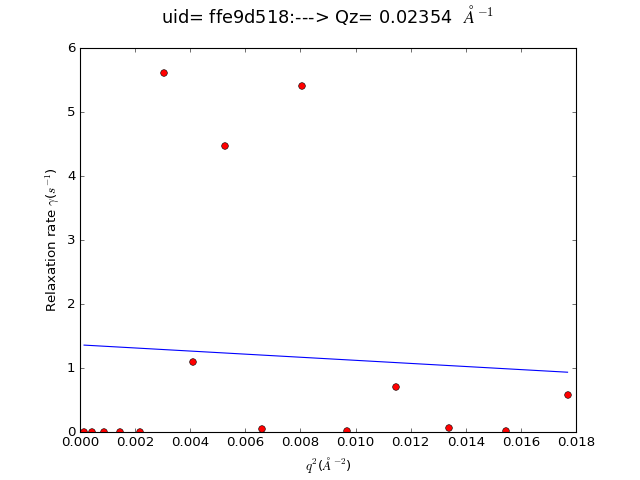

<IPython.core.display.Javascript object>


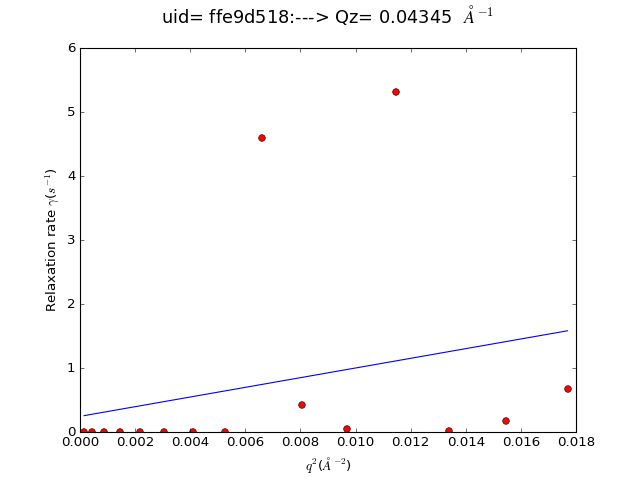

In [103]:
for qz_ind in range(num_qz): 
    fig,ax = plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05)
    ax.plot(qr_center**2, rate[qz_ind], 'ro', ls='')
    ax.plot(qr_center**2,  gmfit[qz_ind](qr_center**2),  ls='-')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Two_time Correlation

In [95]:
good_start= 0
good_end = 15000
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask)

In [108]:
g12b, g12b_not_norm, norms = auto_two_Array_g1_norm( imgsr, box_maskr,
                                            data_pixel = data_pixel ) 

###########Total time: 23.46 min


In [ ]:
#np.save( path + 'g12b_%s-%s--%s'%(uid,good_start, good_end), g12b)

<IPython.core.display.Javascript object>


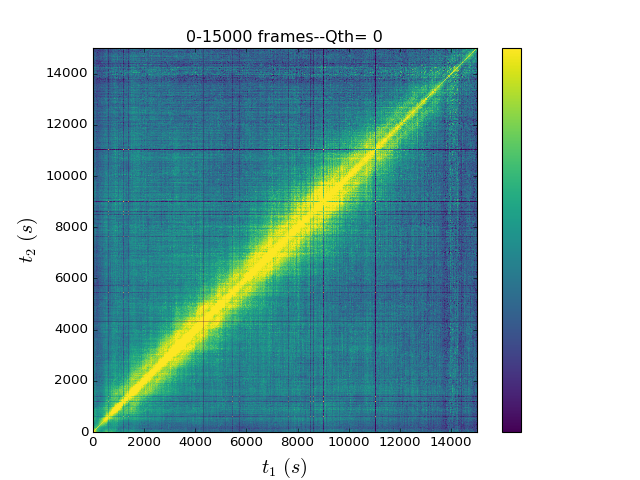

In [109]:
g12_num = 0  #0: the firs box
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1.8, vmax= 2.2 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


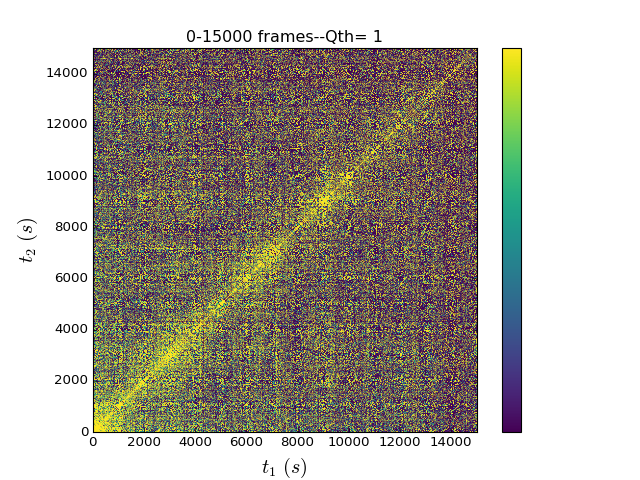

In [110]:
g12_num = 1  #0: the second box
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1.1, vmax= 1.15 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

## find the bad frames and mask it in two-time correlation

<IPython.core.display.Javascript object>


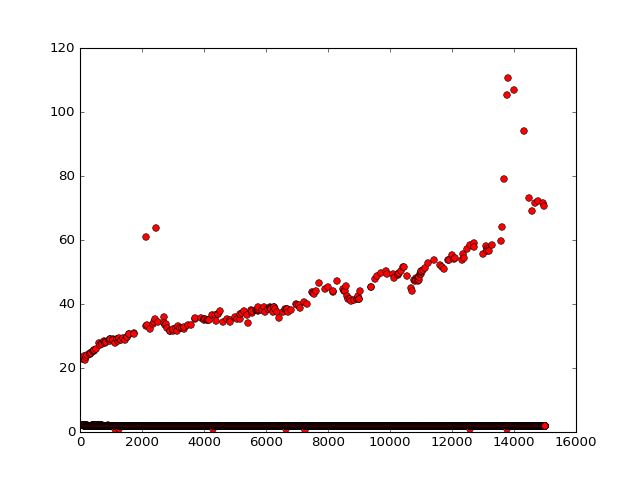

In [111]:
fig,ax = plt.subplots()
ax.plot( g12b[:,:,0][0], 'ro', ls='')

In [112]:
#np.where( g12b[:,:,0] == g12b[:,:,0].min() )

In [113]:
np.where( g12b[:,:,0][0] <1.1)


(array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784]),)

In [114]:
np.where( g12b[:,:,0][100] <1.1)

(array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784]),)

In [115]:
bad_frames = np.where( g12b[:,:,0][100] <1.1)[0]

In [116]:
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

In [117]:
g12b_mask = make_g12_mask(g12b, bad_frames)

In [127]:
g12bm = masked_g12(g12b, g12b_mask)

<IPython.core.display.Javascript object>


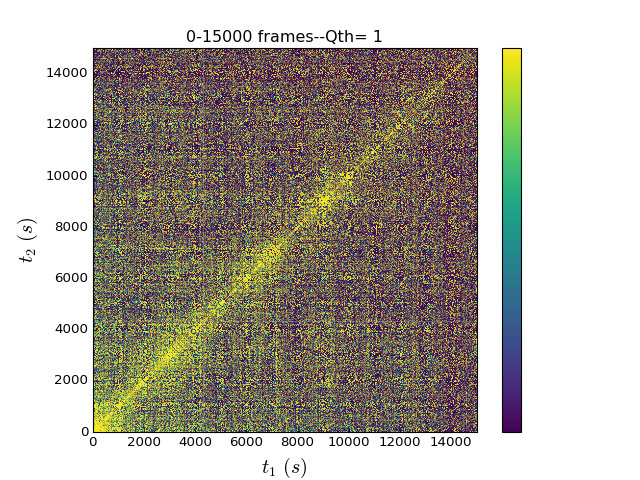

In [129]:
g12_num = 1  #0: the second box
data = g12bm[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1.1, vmax= 1.15 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

### get one time correlation

In [133]:
g2b = get_one_time_from_two_time(g12bm, timeperframe= timeperframe)

<IPython.core.display.Javascript object>


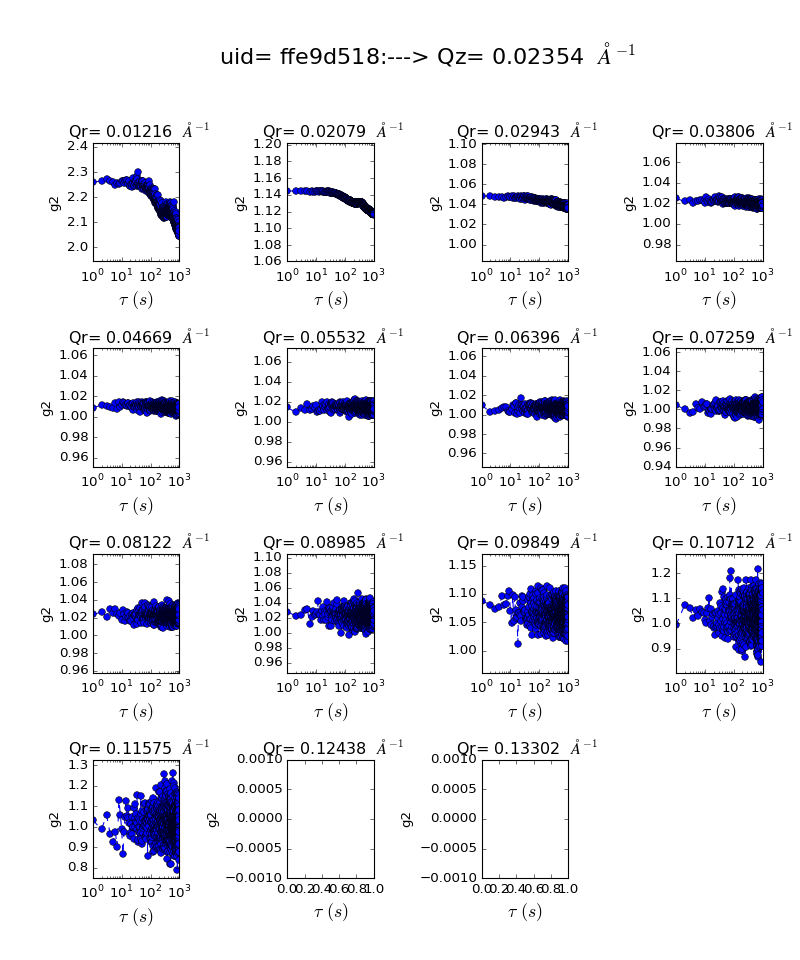

<IPython.core.display.Javascript object>


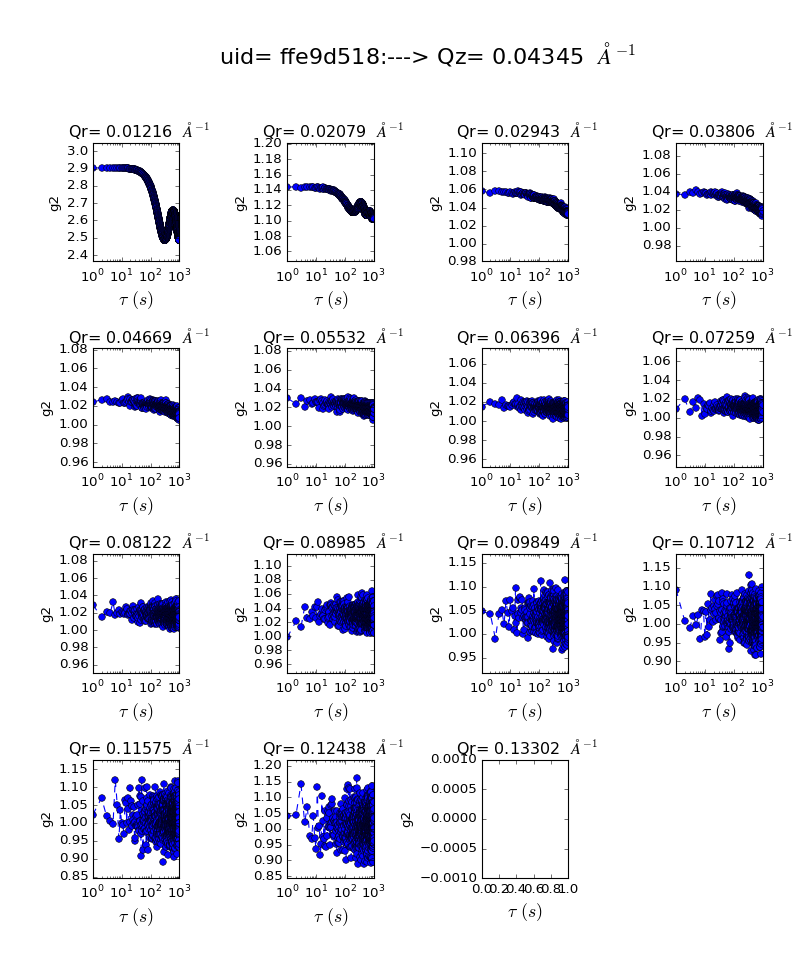

In [168]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y[1:])*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

### plot g2 by multi-tau and g2 from two-time

<IPython.core.display.Javascript object>


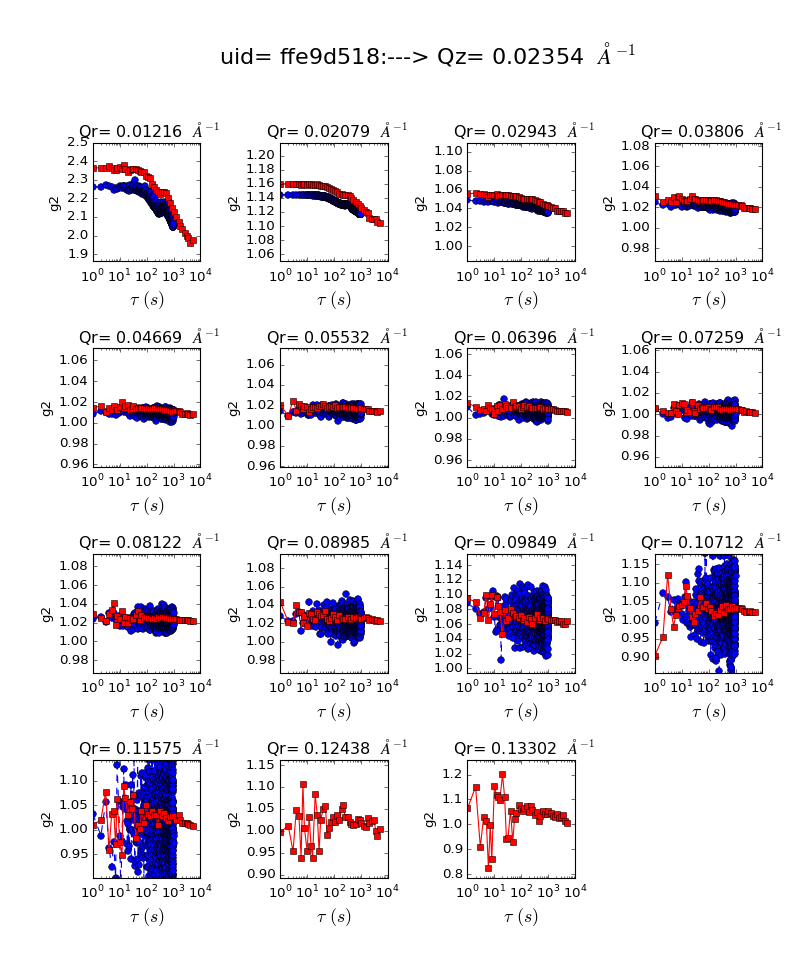

<IPython.core.display.Javascript object>


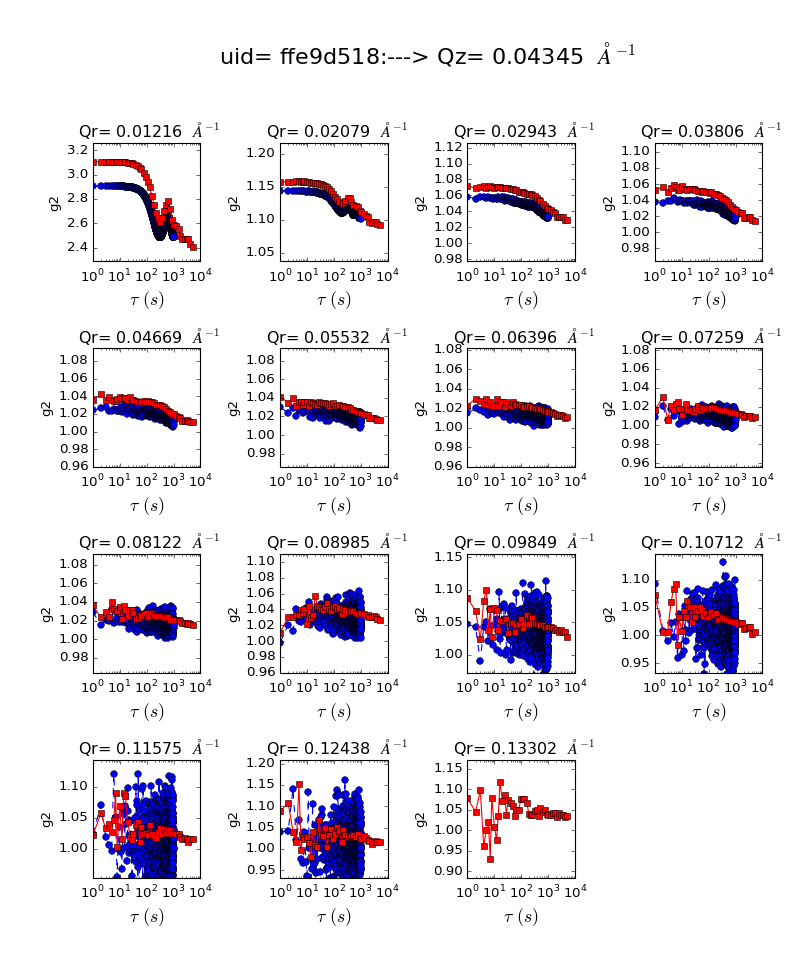

In [170]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        
        y2=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y2, '-rs', markersize=6) 
        #ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        
        ax.set_ylim([min(y2[1:])*.95, max(y2[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

## Another defination of two-time correlation (different normalization)

In [176]:
g12b_not_norm_mask = masked_g12(g12b_not_norm, g12b_mask)

In [194]:
norms_masker = make_norms_mask(norms, bad_frames)

In [195]:
norms_mask = masked_norms( norms, norms_masker)

In [230]:
g2b_not_norm = get_one_time_from_two_time(g12b_not_norm_mask,
            norms=norms_mask, nopr=nopr - len(bad_frames), timeperframe= timeperframe)

<IPython.core.display.Javascript object>


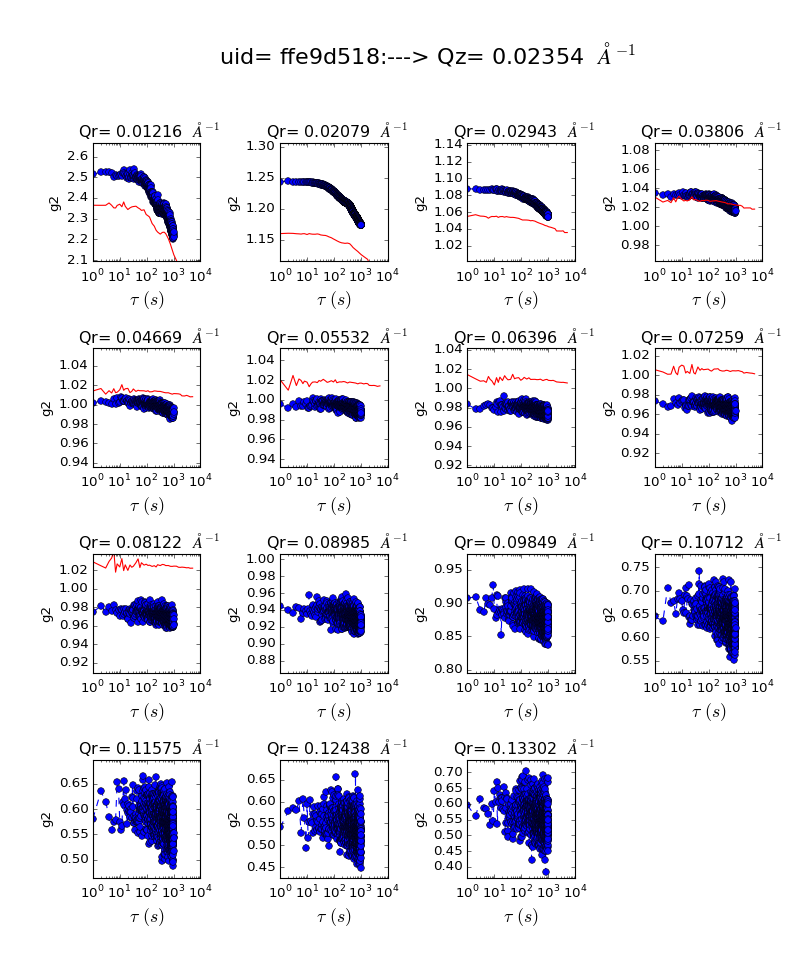

<IPython.core.display.Javascript object>


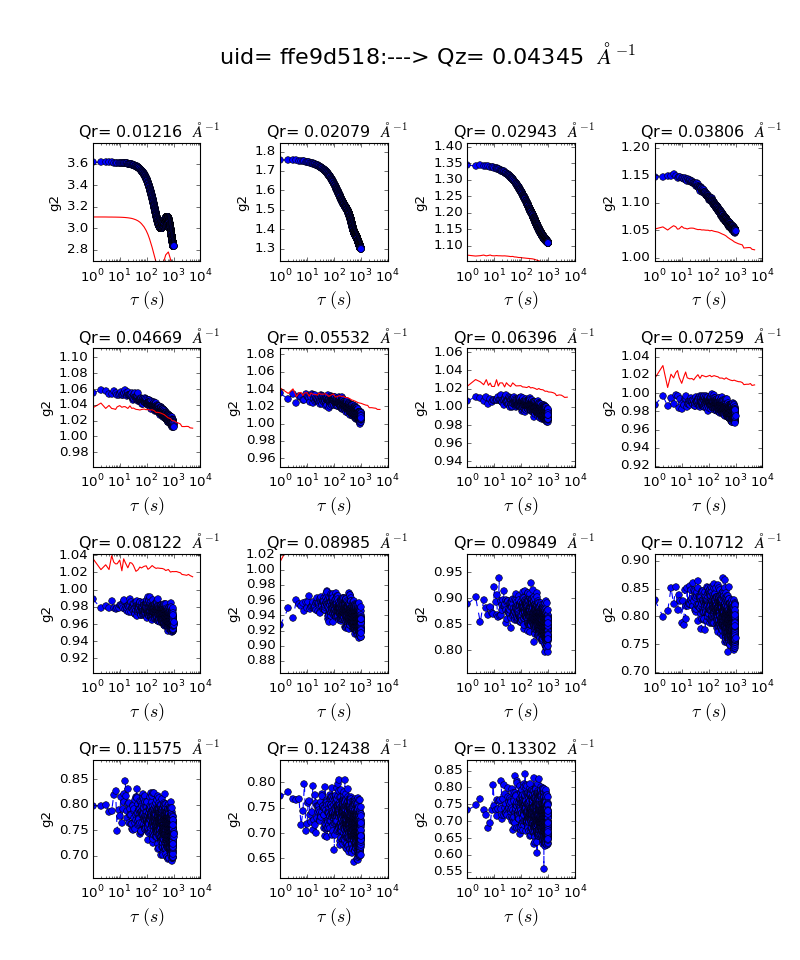

In [232]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b_not_norm[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        
        y2=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y2, '-r', markersize=3) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        
        #ax.set_ylim([min(y2[1:])*.95, max(y2[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

### get one time correlation @different age

the cut age centers are: [  8000.  15000.  22000.]


<IPython.core.display.Javascript object>


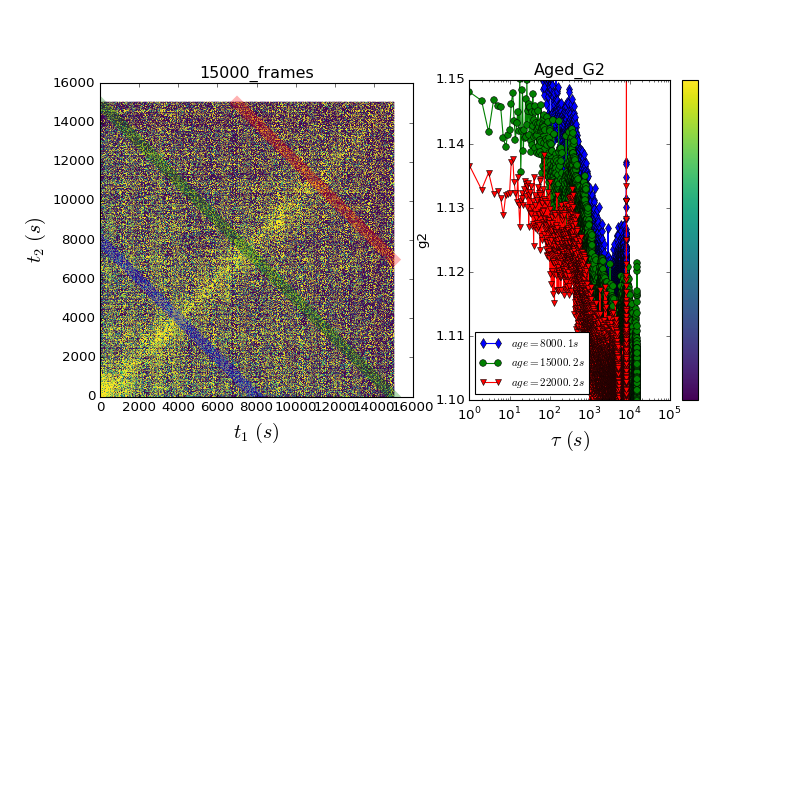

In [245]:
g12_num =1

g2b = show_g12_age_cuts( g12bm, g12_num=g12_num, slice_num =3, slice_width= 500, 
                slice_start=8000, slice_end= 2*15000-8000,
    timeperframe= timeperframe,vmin= 1.1, vmax =  1.15) #vmax=g12b[:,:,g12_num].max() )

# get taus histgram

the cut tau centers are: [  3.00000000e+00   2.50200000e+03   5.00100000e+03   7.50000000e+03
   9.99900000e+03]


<IPython.core.display.Javascript object>


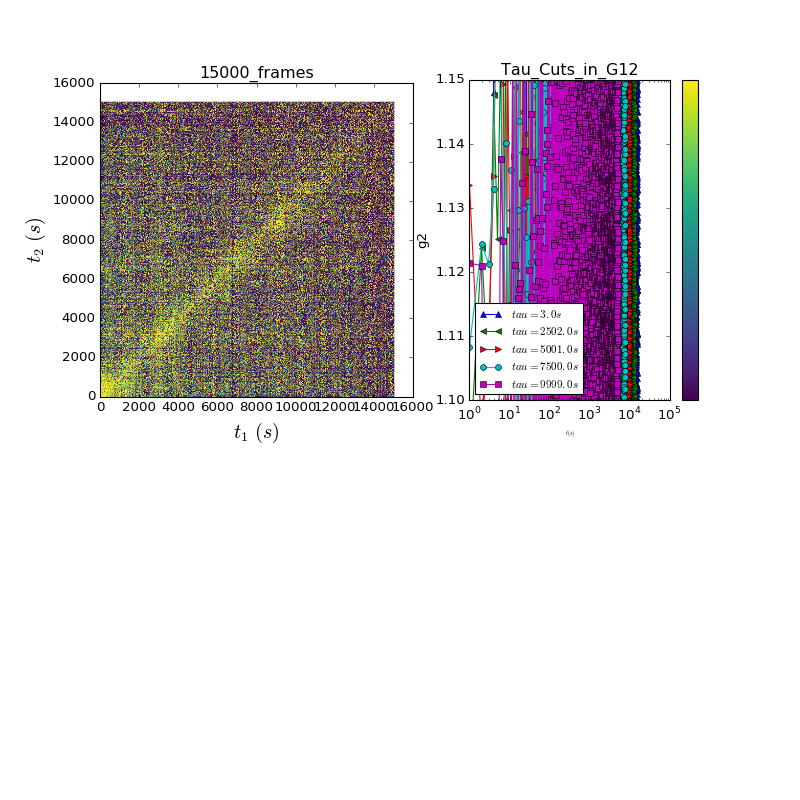

In [246]:
taus = show_g12_tau_cuts(g12bm, g12_num=1,  slice_num = 5, slice_width= 1.0, 
    slice_start=3, slice_end= 10000-1,draw_scale_tau =5.0, vmin=1.1,vmax=1.15 )

<IPython.core.display.Javascript object>


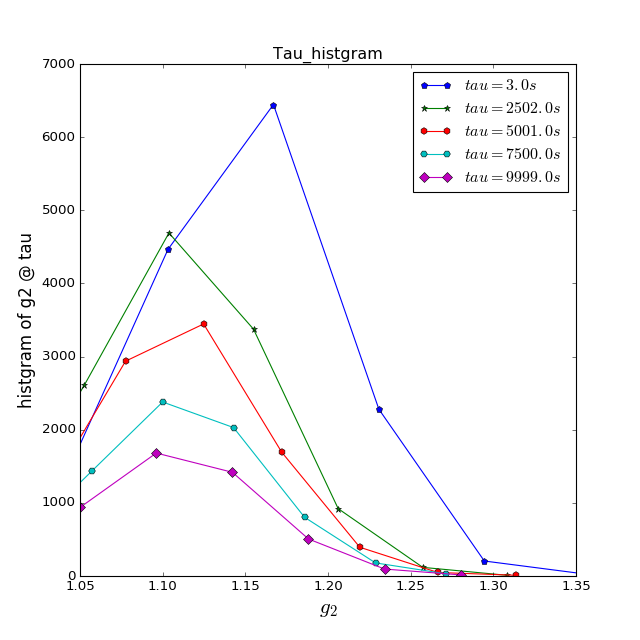

In [247]:
his = his_tau(taus, hisbin = 10, plot=True)